In [1]:
using Statistics
using StatsModels
using GLM
using CSV
using DataFrames
#using Plots
using Gadfly

### Preprocess

In [2]:

function scale(X)
    X_mean= mean(X, dims=1)
    X_std = std(X, dims=1)

    X_norm = (X .- X_mean) ./ X_std
    
    return X_norm, X_mean, X_std
end


function scale_transform(X, X_mean, X_std)
    
    X_norm = (X .- X_mean) ./ X_std
    return X_norm
end


function sigmoid(z)
    return 1 ./ (1 .+ exp.(.-z))
end

sigmoid (generic function with 1 method)

In [3]:
_, X_mean, X_std = scale(X)

scale_transform(X, X_mean, X_std)

LoadError: UndefVarError: X not defined

### Data

* <b>Subjects</b>: 400 subjects (male) from retrospective cohort study hospital with suspected MI.
* <b>Outcome</b>: 30-day mortality (death=1)
* <b>Intervention</b>: Rapid administration of a new clot-busting drug (trt=1) versus a standard therapy (trt=0)
* <b>Source</b>: http://web.hku.hk/~bcowling/data/propensity.csv

In [94]:
df = CSV.File("../../data/propensity.csv") |> DataFrame;
head(df)

,age,male,risk,severity,trt,death
,Int64,Int64,Int64,Int64,Int64,Int64
1,48,1,3,8,0,0
2,59,1,4,6,1,0
3,67,1,3,6,0,1
4,51,1,0,6,0,0
5,56,1,1,6,1,0
6,60,1,1,6,0,0


In [95]:
size(df)

(400, 6)

In [96]:
df_train = df[begin:300,:]
df_test = df[300:end,:];

In [97]:
println(names(df))

["age", "male", "risk", "severity", "trt", "death"]


### Calculate Propensity Score of Treatment

In [98]:
# Propensity for intervetion given covariates
fm = @formula(trt ~ age + risk + severity)

FormulaTerm
Response:
  trt(unknown)
Predictors:
  age(unknown)
  risk(unknown)
  severity(unknown)

In [99]:
logit = glm(fm, df_train, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

trt ~ 1 + age + risk + severity

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -3.31244     0.986663   -3.36    0.0008  -5.24626     -1.37862
age           0.0403817   0.0182184   2.22    0.0267   0.00467423   0.0760892
risk          0.176141    0.105609    1.67    0.0953  -0.0308482    0.383131
severity      0.124517    0.0615208   2.02    0.0430   0.00393811   0.245095
─────────────────────────────────────────────────────────────────────────────

In [105]:
propensity_scores = predict(logit, df_train)

df_train[!,Symbol("Propensity_Scores")] = propensity_scores;

In [124]:
mean(df_train[df_train[!, :Treatment] .== "Treatment", :Propensity_Scores])

0.5186186964104783

In [125]:
mean(df_train[df_train[!, :Treatment] .== "No Treatment", :Propensity_Scores])

0.4268854831876268

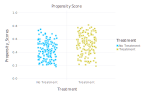

In [106]:
df_train[!, Symbol("Treatment")] .= ifelse.(
  df_train.trt .== 1, "Treatment", "No Treatment");

plot(
df_train,
    x=:Treatment,
    y=:Propensity_Scores, 
color=:Treatment,
    Stat.x_jitter(range=0.5),
Guide.title("Propensity Score")
)

#### Generate propensity scores on new data

In [107]:
prediction = predict(logit, df_test);

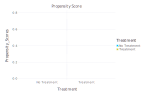

In [109]:
df_test[!,Symbol("Propensity_Scores")] = prediction;

df_test[!, Symbol("Treatment")] .= ifelse.(
  df_test.trt .== 1, "Treatment", "No Treatment");

plot(
df_test,
    x=:Treatment,
    y=:Propensity_Scores, 
color=:Treatment,
    Stat.x_jitter(range=0.5),
Guide.title("Propensity Score")
)
# plot(x=1:length(sds), y=ys, ymin=ymins, ymax=ymaxs,
#      Geom.point, Geom.errorbar)